1. Import Libraries 

2. Load and Preprocess Data

3. Create the Dataset and DataLoader Objects

4. Define the CNN Model

5. Train the Model

6. Evaluate the Model on Test Data

7. Save the Trained Model

8. Create a Simple Web App for Classification

<h3> Step 1. Import Libraries

Here’s a list of essential libraries we’ll need:

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from PIL import Image
import numpy as np

Explanation of the Libraries (for reference):

os: To interact with the file system.

torch and torch.nn: Core PyTorch libraries for building and training models.

torch.optim: To set up our optimizer for model training.

DataLoader and Dataset: For efficient data loading.

torchvision.transforms: For image transformations (resizing, normalization, etc.).

torchvision.datasets: Contains helper functions like ImageFolder to load labeled images from folders.

torchvision.models: For accessing pre-trained models if needed.

PIL (Python Imaging Library): To handle images.

numpy: For array operations, although we'll use PyTorch tensors for most calculations.


<h3> Step 2: Load and Preprocess Data </h3>



<h4> 2.1 Specify Paths and Define Transforms </h4>

First, let’s define the paths for our dataset and some transformations to resize and normalize images before feeding them into the model.

Since my dataset organized in folders and want to split it into an 80-20 train-test split, let’s handle that in two steps: dividing the data and creating our loaders.

In [2]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Define main data directory and target train/test directories
data_dir = '../classify_'
train_dir = '../classify_/train'
test_dir = '../classify_/test'

# Create directories for training and testing sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for label in ['stop', 'not-stop']:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Split and move files
for label in ['stop', 'not-stop']:
    images = os.listdir(os.path.join(data_dir, label))
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    for image in train_images:
        shutil.copy(os.path.join(data_dir, label, image), os.path.join(train_dir, label, image))
    for image in test_images:
        shutil.copy(os.path.join(data_dir, label, image), os.path.join(test_dir, label, image))

In [3]:
# Define transformations (same as before)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the train and test data using ImageFolder
train_data = ImageFolder(root=train_dir, transform=transform)
test_data = ImageFolder(root=test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

This will split the data into an 80-20 ratio and create the train and test data loaders.

<h3> Step 3: Load a Pre-Trained model and Customize it

Now, we’ll load a pre-trained model and customize it for our specific two-class problem. In this case, let's use a pre-trained ResNet18 model and modify its final layer to output two classes (for "stop" and "non-stop").

In [4]:
import torch
import torch.nn as nn
from torchvision import models

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to output 2 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

/home/amu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This setup uses a ResNet18 model, freezes all layers except the last fully connected layer (so only the final layer will be trained), and customizes the last layer to output two classes.

<h3> Step 4: Define Loss Function and Optimizer


Now we’ll set up the training process, including defining the loss function and optimizer. We’ll use cross-entropy loss since it’s suitable for classification tasks, and we’ll use the Adam optimizer, which generally works well for most models.

In [5]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Explanation:

criterion: Cross-entropy loss is used here, as it’s ideal for multi-class classification.

optimizer: We only update the final layer (model.fc.parameters()), so we’re using the Adam optimizer to adjust those weights.

This prepares us for the training loop!

<h3> Step 5: Train the Model


Now we’ll create the training loop to train our model. This involves iterating through each batch of training data, calculating the loss, performing backpropagation, and updating the weights. After each epoch, we’ll also check the performance on the validation set to track progress.

In [6]:
import matplotlib.pyplot as plt

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 10  # You can adjust this as needed

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Append training loss

    # Evaluate on validation set
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)  # Append validation loss
    val_accuracies.append(accuracy)   # Append validation accuracy

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Validation Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch [1/10], Train Loss: 0.6304, Validation Loss: 0.4469, Validation Accuracy: 90.00%
Epoch [2/10], Train Loss: 0.4207, Validation Loss: 0.4144, Validation Accuracy: 83.75%
Epoch [3/10], Train Loss: 0.3355, Validation Loss: 0.2787, Validation Accuracy: 93.75%
Epoch [4/10], Train Loss: 0.2799, Validation Loss: 0.2791, Validation Accuracy: 88.75%
Epoch [5/10], Train Loss: 0.2674, Validation Loss: 0.2391, Validation Accuracy: 92.50%
Epoch [6/10], Train Loss: 0.2414, Validation Loss: 0.2193, Validation Accuracy: 95.00%
Epoch [7/10], Train Loss: 0.2102, Validation Loss: 0.2141, Validation Accuracy: 93.75%
Epoch [8/10], Train Loss: 0.1985, Validation Loss: 0.2051, Validation Accuracy: 95.00%
Epoch [9/10], Train Loss: 0.2054, Validation Loss: 0.1955, Validation Accuracy: 95.00%
Epoch [10/10], Train Loss: 0.1797, Validation Loss: 0.1922, Validation Accuracy: 95.00%
Training complete.


<h3> Step 6: Save the Model and Visualize Results

<h4> Saving the Model


In [7]:
# Step 6: Save the trained model
torch.save(model.state_dict(), 'resnet18_stop_sign_classifier.pth')
print("Model saved successfully.")


Model saved successfully.


<h4> Visualizing Training Results </h4>

You can use Matplotlib to visualize the training and validation loss and accuracy over epochs. Here’s a simple way to do that:



Train losses: 10, Validation losses: 10, Validation accuracies: 10


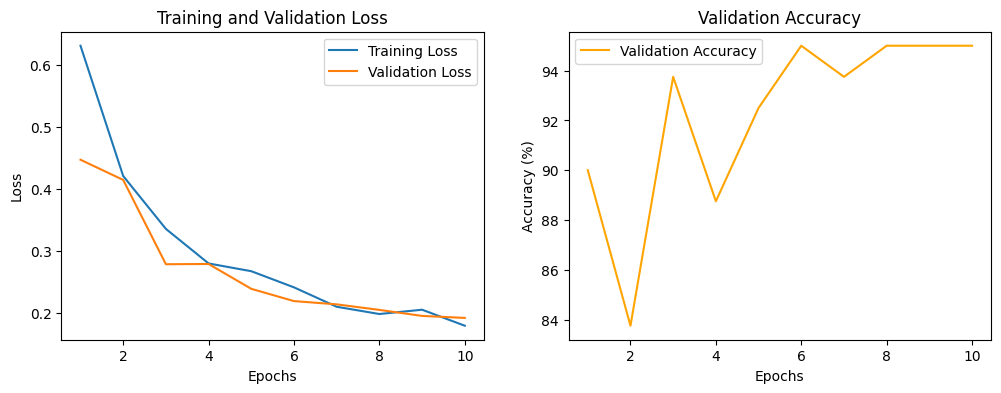

In [8]:

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))

# Check the lengths of the lists before plotting
print(f"Train losses: {len(train_losses)}, Validation losses: {len(val_losses)}, Validation accuracies: {len(val_accuracies)}")

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


<h3> Step 7: Testing the model

In [9]:
# Test the model
model.eval()  # Set the model to evaluation mode
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 95.00%


<h3> Step 8: Evaluate the Model

In [10]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


Accuracy of the model on the test set: 95.00%
